In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import random
import shap

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, roc_curve, auc, confusion_matrix

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
df = pd.read_csv(r'C:\Users\shams\downloads\ss\FINALDATASET.csv')
df.head()

,SORA,orig_amounts,aadt_truck,comm_workers_per_car,comm_workhome,hhd_no,hhd_avg_size,hhd_mean_income,ind_whole,landuse_code,ROAD_DIREC,Longitude,Latitude
0,1,8870872.73,8118.0,1.064648,4.726761,2503.563380,2.746056,68478.18310,63.183099,2110,8,-81.809291,28.656131
1,1,1013907.49,419.0,1.074000,3.166667,1255.457143,2.634000,56668.46667,28.066667,2120,3,-80.944513,27.333484
2,0,902867.82,783.0,1.072778,4.138889,1255.457143,2.687222,59760.22222,29.000000,2120,3,-80.740139,27.203052
3,1,3548288.43,624.0,1.042500,9.045714,2061.485714,2.592571,72644.31429,89.914286,4120,2,-81.960107,29.870178
4,1,3175000.00,783.0,1.057612,8.300000,1436.373134,2.368955,65153.97015,23.358209,1200,1,-80.986029,29.179011


In [3]:
X = df.drop(['SORA', 'Longitude', 'Latitude'],axis=1)
y = df['SORA']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

# 1. Fine-tuning the improved CatBoost Model using top ten features
Adjusting best parameters using previously performed 4-fold Cross Validation

0:	learn: 0.6889666	test: 0.6880208	best: 0.6880208 (0)	total: 97.8ms	remaining: 1m 37s
200:	learn: 0.4235162	test: 0.3758485	best: 0.3758485 (200)	total: 454ms	remaining: 1.8s
400:	learn: 0.3619890	test: 0.3427648	best: 0.3427648 (400)	total: 907ms	remaining: 1.35s
600:	learn: 0.3168719	test: 0.3316565	best: 0.3306746 (590)	total: 1.24s	remaining: 822ms
800:	learn: 0.2817216	test: 0.3212486	best: 0.3209936 (798)	total: 1.52s	remaining: 377ms
999:	learn: 0.2482874	test: 0.3112808	best: 0.3112757 (977)	total: 1.74s	remaining: 0us

bestTest = 0.3112756804
bestIteration = 977

Shrink model to first 978 iterations.
Training Accuracy: 0.9
Testing Accuracy: 0.9
F1 Score: 0.94
Precision: 0.91
Recall: 0.98
ROC AUC: 0.84


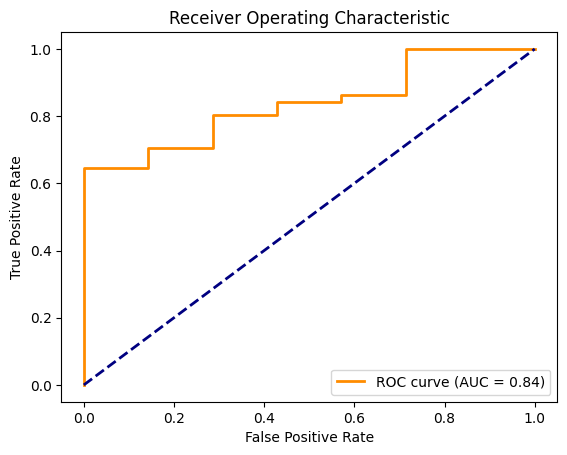

In [5]:
best_params = {'depth': 3, 'l2_leaf_reg': 18, 'learning_rate': 0.01}

best_model = CatBoostClassifier(iterations=1000, **best_params)
best_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=200)

y_pred = best_model.predict(X_test)
y_train_pred = best_model.predict(X_train)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy  = accuracy_score(y_test, y_pred)
f1             = f1_score(y_test, y_pred)
precision      = precision_score(y_test, y_pred)
recall         = recall_score(y_test, y_pred)
roc_auc        = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])


print(f"Training Accuracy: {train_accuracy.round(2)}")
print(f"Testing Accuracy: {test_accuracy.round(2)}")
print(f"F1 Score: {f1.round(2)}")
print(f"Precision: {precision.round(2)}")
print(f"Recall: {recall.round(2)}")
print(f"ROC AUC: {roc_auc.round(2)}")

#Plot ROC AUC Curve
fpr, tpr, _ = roc_curve(y_test, best_model.predict_proba(X_test)[:, 1])
roc_auc_curve = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

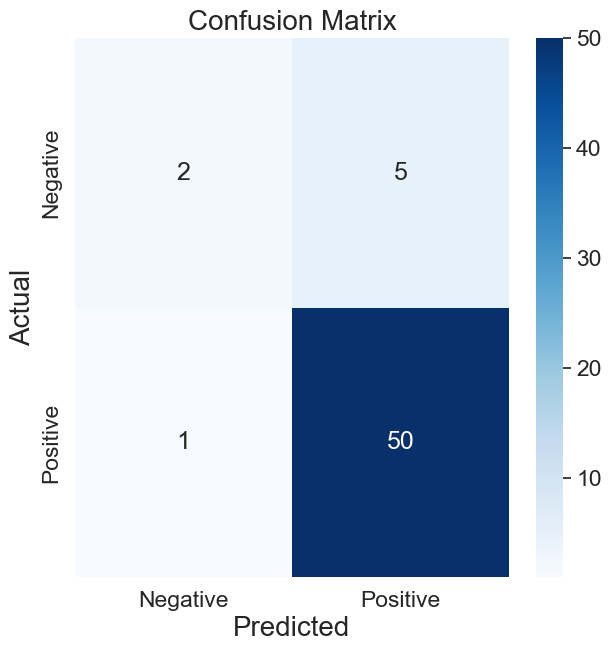

In [6]:
#Plotting Confusion Matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
class_names = ['Negative', 'Positive']
font_size = 20
plt.figure(figsize=(7, 7))
sns.set(font_scale=1.5)
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted', fontsize=font_size)
plt.ylabel('Actual', fontsize=font_size)
plt.title('Confusion Matrix', fontsize=font_size)
plt.show()

In [7]:
#Predictions on the whole dataset
y_all_data = best_model.predict(X)

In [8]:
'''confusion_matrix = confusion_matrix(y, y_all_data)
class_names = ['Negative', 'Positive']
font_size = 20
plt.figure(figsize=(7, 7))
sns.set(font_scale=1.5)
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted', fontsize=font_size)
plt.ylabel('Actual', fontsize=font_size)
plt.title('Confusion Matrix', fontsize=font_size)
plt.show()'''

"confusion_matrix = confusion_matrix(y, y_all_data)\nclass_names = ['Negative', 'Positive']\nfont_size = 20\nplt.figure(figsize=(7, 7))\nsns.set(font_scale=1.5)\nsns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)\nplt.xlabel('Predicted', fontsize=font_size)\nplt.ylabel('Actual', fontsize=font_size)\nplt.title('Confusion Matrix', fontsize=font_size)\nplt.show()"

In [9]:
# Calculating Confusion Matrix values for each record (to be used for visulaization on Map of Florida)
results = pd.DataFrame({'True_Label': y, 'Predicted_Label': y_all_data})

results['TP'] = (results['True_Label'] == 1) & (results['Predicted_Label'] == 1)
results['FP'] = (results['True_Label'] == 0) & (results['Predicted_Label'] == 1)
results['TN'] = (results['True_Label'] == 0) & (results['Predicted_Label'] == 0)
results['FN'] = (results['True_Label'] == 1) & (results['Predicted_Label'] == 0)

results = results.astype(int)
print(results)

     True_Label  Predicted_Label  TP  FP  TN  FN
0             1                1   1   0   0   0
1             1                1   1   0   0   0
2             0                1   0   1   0   0
3             1                1   1   0   0   0
4             1                1   1   0   0   0
..          ...              ...  ..  ..  ..  ..
283           1                1   1   0   0   0
284           1                1   1   0   0   0
285           1                1   1   0   0   0
286           0                1   0   1   0   0
287           0                1   0   1   0   0

[288 rows x 6 columns]


# 2. Extracting Feature Importances Using SHAP Values

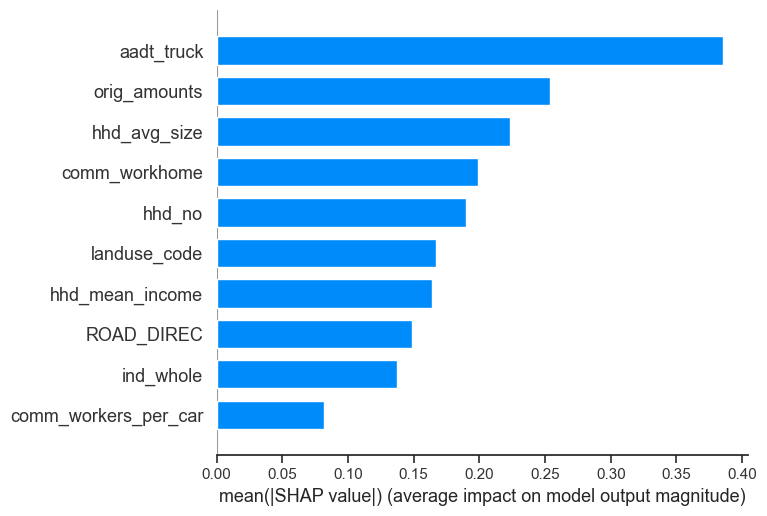

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


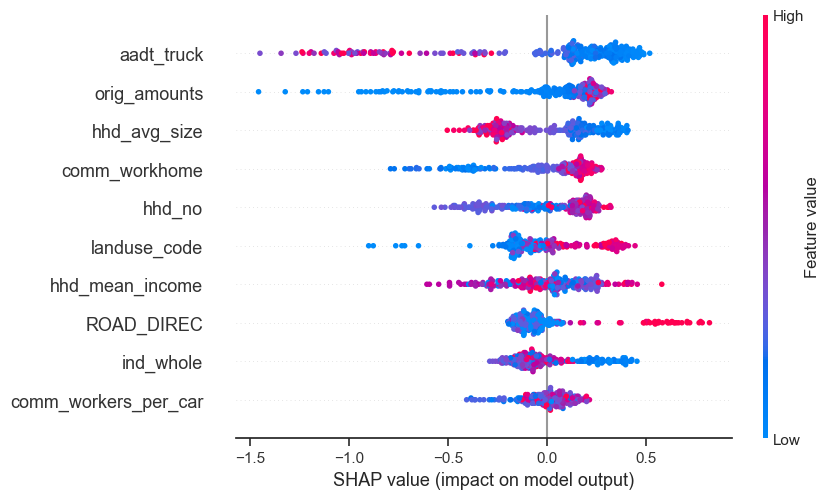

In [10]:
shap.initjs()
sns.set_style(style='white')

explainer_tree = shap.TreeExplainer(best_model)
shap_values_tree = explainer_tree.shap_values(X)
shap.summary_plot(shap_values_tree, X.columns, plot_type='bar')

explainer = shap.Explainer(best_model)
shap_values = explainer(X)
shap.plots.beeswarm(shap_values)

In [11]:
feature_names = X_train.columns
feature_importances = pd.DataFrame(shap_values.values, columns = feature_names)

vals = np.abs(feature_importances.values).mean(0)

shap_importance = pd.DataFrame(list(zip(feature_names, vals)), columns=['Feature','importance'])
shap_importance.sort_values(by=['importance'],ascending=False, inplace=True)

shap_importance['Relative Importance'] = (shap_importance.importance / shap_importance.importance.max())* 100
shap_importance

,Feature,importance,Relative Importance
1,aadt_truck,0.385488,100.000000
0,orig_amounts,0.253565,65.777619
5,hhd_avg_size,0.223433,57.961124
3,comm_workhome,0.198934,51.605766
4,hhd_no,0.189615,49.188424
8,landuse_code,0.167273,43.392588
6,hhd_mean_income,0.164031,42.551527
9,ROAD_DIREC,0.148384,38.492419
7,ind_whole,0.137661,35.710859
2,comm_workers_per_car,0.081918,21.250556


## 2.1. Extracting Features SHAP Values (To Be Used in Geographic Information System (GIS) Visualization)

In [12]:
shap_values_for_GIS = pd.DataFrame(shap_values.values, columns = feature_names)
shap_values_for_GIS
#shap_values_for_GIS.to_csv('shap_values_for_GIS.csv', encoding='utf-8', index=False)

,orig_amounts,aadt_truck,comm_workers_per_car,comm_workhome,hhd_no,hhd_avg_size,hhd_mean_income,ind_whole,landuse_code,ROAD_DIREC
0,0.300141,-0.780235,0.059080,0.032771,0.319880,-0.157361,0.050888,0.069254,-0.144281,0.777693
1,0.090021,0.437968,-0.025564,-0.436907,-0.087820,-0.085258,0.050549,0.262957,-0.205542,-0.067848
2,-0.003615,0.334290,-0.092113,-0.696574,-0.118406,-0.347667,0.014283,0.014848,-0.225130,-0.079611
3,0.235924,0.397114,0.038635,0.225194,0.171432,0.017537,0.146323,-0.087492,0.024764,-0.127485
4,0.181301,0.383978,0.007163,0.220428,-0.009513,0.361128,0.161962,0.253261,-0.197137,-0.112736
...,...,...,...,...,...,...,...,...,...,...
283,0.231717,-0.474534,0.020018,0.159735,0.183412,0.021469,0.428000,0.044370,-0.149528,-0.048302
284,0.225889,-0.524949,0.009456,0.134538,0.202957,-0.245411,0.156446,-0.079648,-0.142822,-0.125315
285,0.195128,0.152325,-0.157198,0.161925,-0.316747,0.215334,-0.117545,-0.132805,0.099415,0.040404
286,0.035850,-0.640919,-0.140251,0.077152,-0.569225,-0.337627,0.388886,-0.239596,-0.172845,-0.147231


## 2.2. Plotting SHAP scatter plots with respect to the correlated features

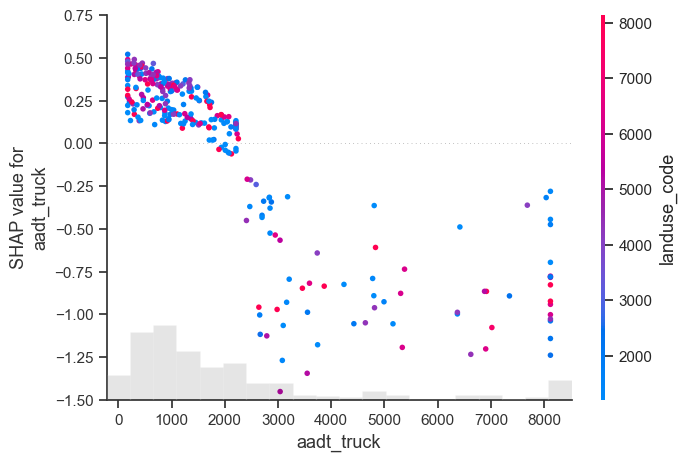

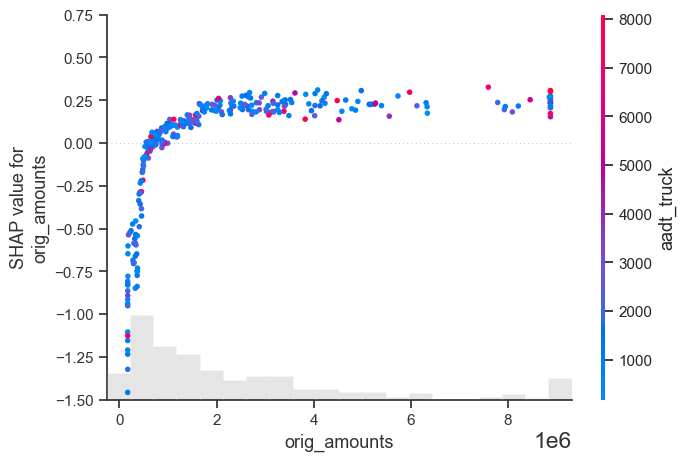

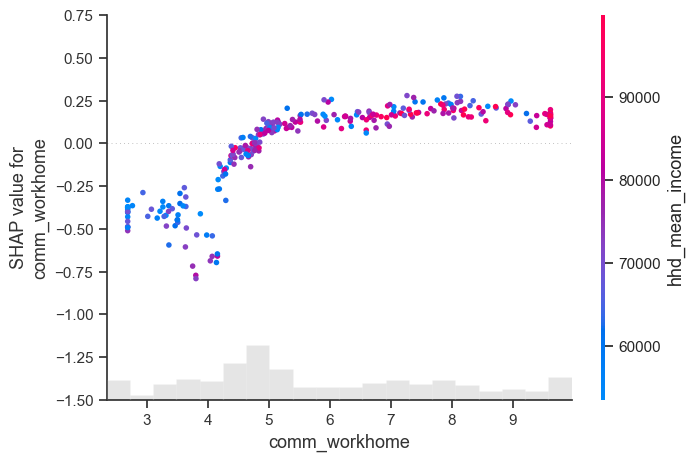

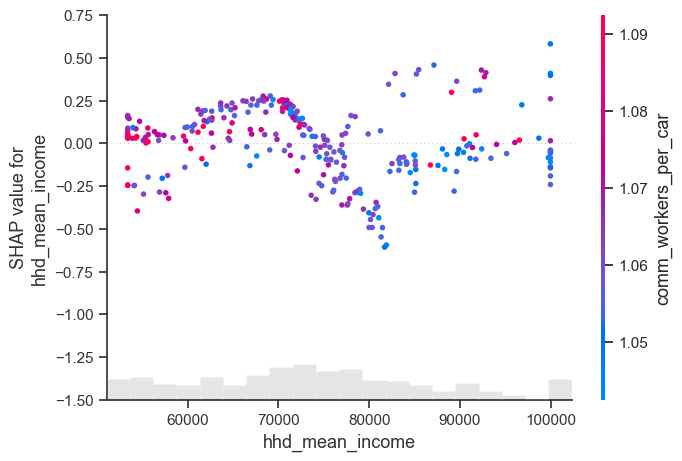

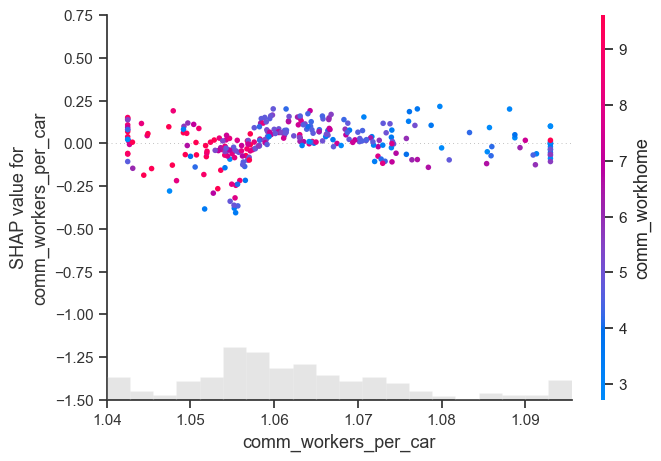

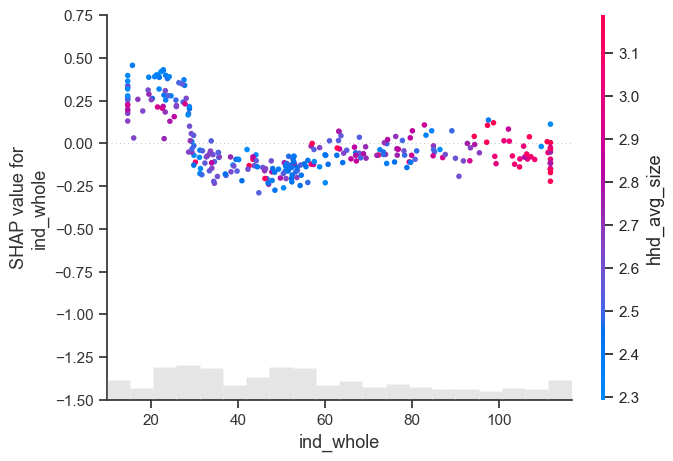

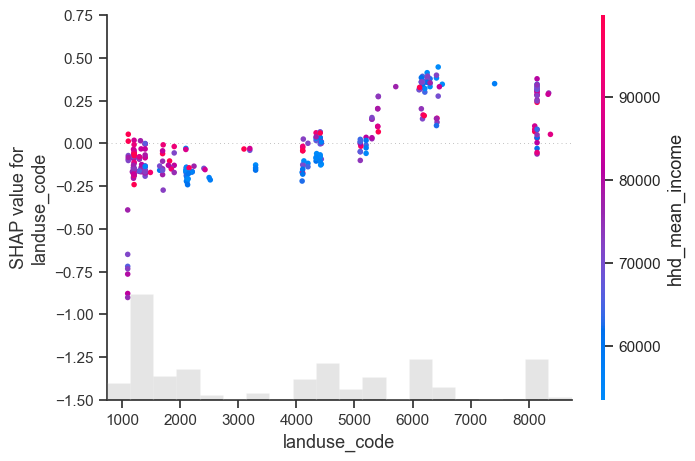

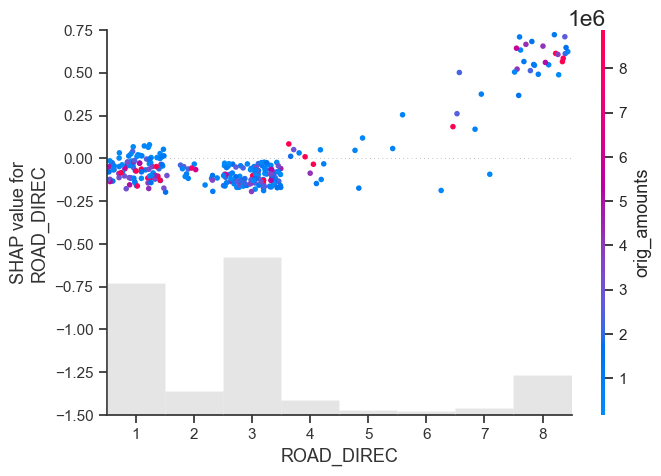

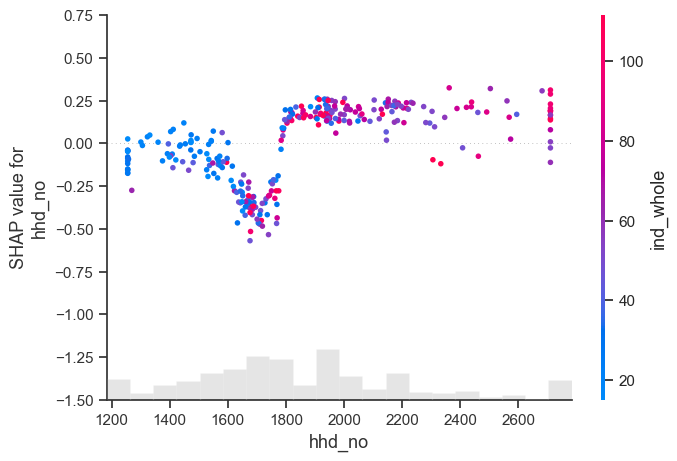

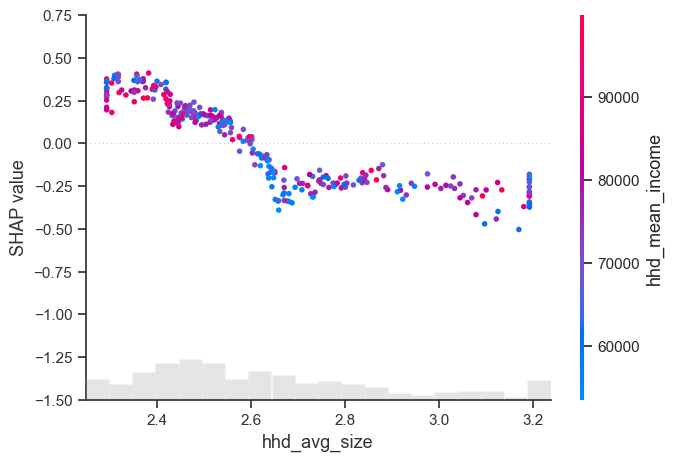

In [13]:
shap.plots.scatter(shap_values[:,"aadt_truck"], color=shap_values[:,"landuse_code"], ymin=-1.5, ymax=0.75, show=False)
shap.plots.scatter(shap_values[:,"orig_amounts"], color=shap_values[:,"aadt_truck"], ymin=-1.5, ymax=0.75, show=False)
shap.plots.scatter(shap_values[:,"comm_workhome"], color=shap_values[:,"hhd_mean_income"], ymin=-1.5, ymax=0.75, show=False)
shap.plots.scatter(shap_values[:,"hhd_mean_income"], color=shap_values[:,"comm_workers_per_car"], ymin=-1.5, ymax=0.75, show=False)
shap.plots.scatter(shap_values[:,"comm_workers_per_car"], color=shap_values[:,"comm_workhome"], ymin=-1.5, ymax=0.75, show=False)
shap.plots.scatter(shap_values[:,"ind_whole"], color=shap_values[:,"hhd_avg_size"], ymin=-1.5, ymax=0.75, show=False)
shap.plots.scatter(shap_values[:,"landuse_code"], color=shap_values[:,"hhd_mean_income"], ymin=-1.5, ymax=0.75, show=False)
shap.plots.scatter(shap_values[:,"ROAD_DIREC"], color=shap_values[:,"orig_amounts"],x_jitter=20, ymin=-1.5, ymax=0.75, show=False)
shap.plots.scatter(shap_values[:,"hhd_no"], color=shap_values[:,"ind_whole"], ymin=-1.5, ymax=0.75, show=False)
shap.plots.scatter(shap_values[:,"hhd_avg_size"], color=shap_values[:,"hhd_mean_income"], ymin=-1.5, ymax=0.75, show=False)
plt.ylabel("SHAP value")
plt.show()

# 2.3. Partial Dependence Plots

In [14]:
def model_feature_proba(x):
    return best_model.predict_proba(x)[:,1]
def model_feature_log_odds(x):
    p = best_model.predict_log_proba(x)
    return p[:,1] - p[:,0]

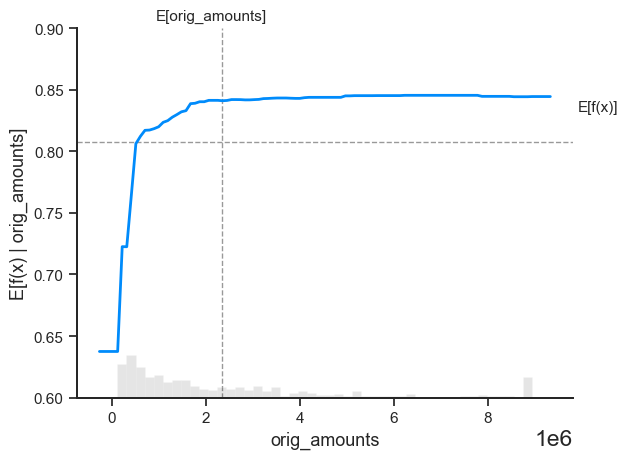

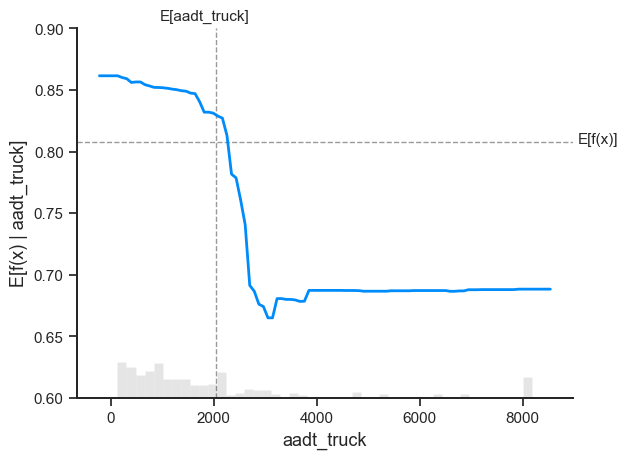

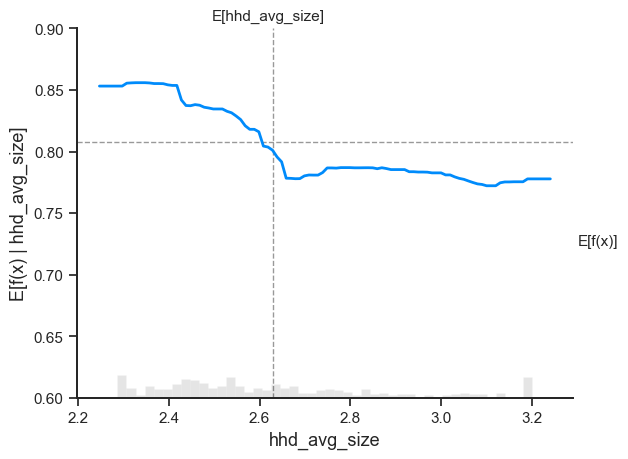

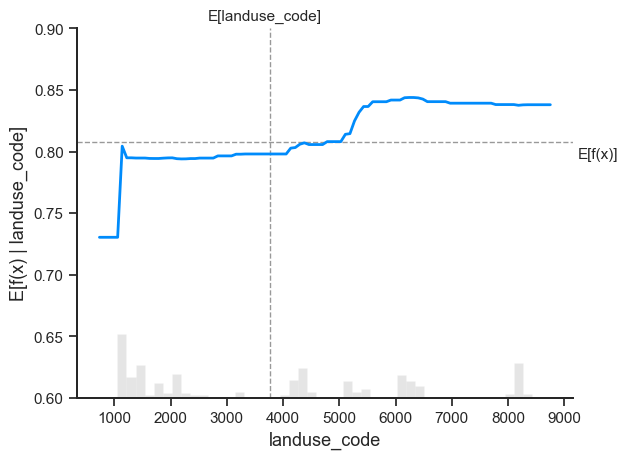

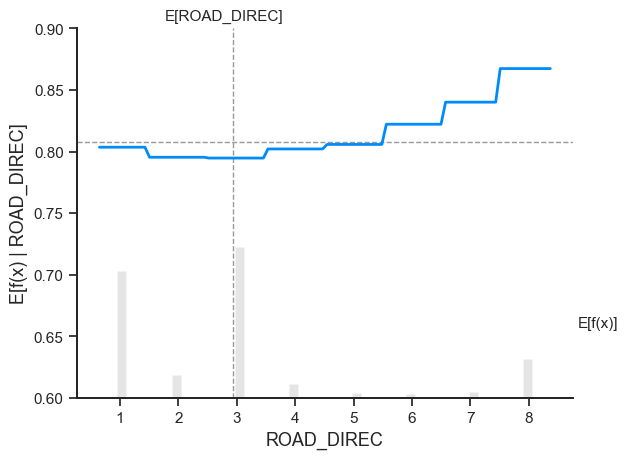

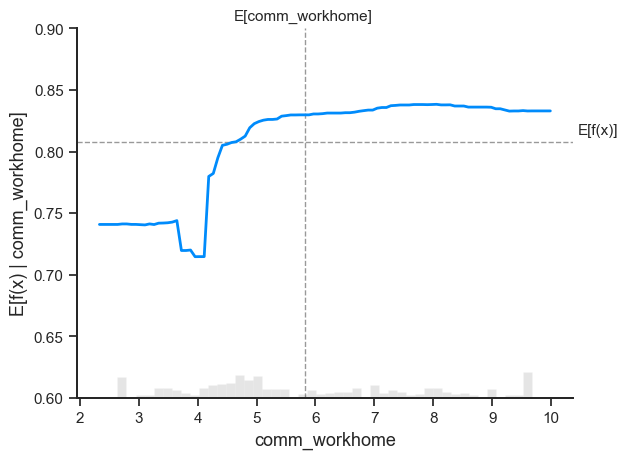

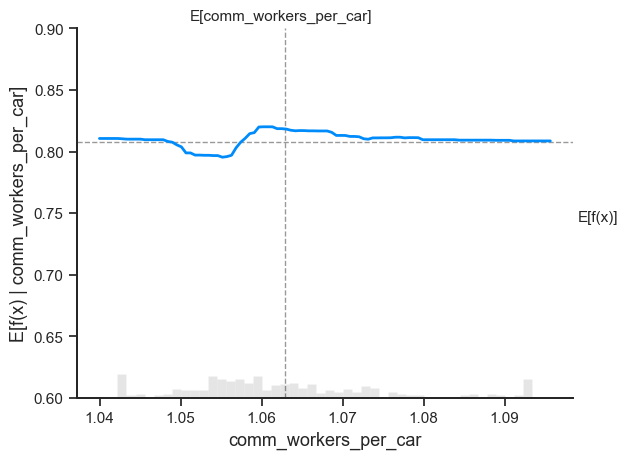

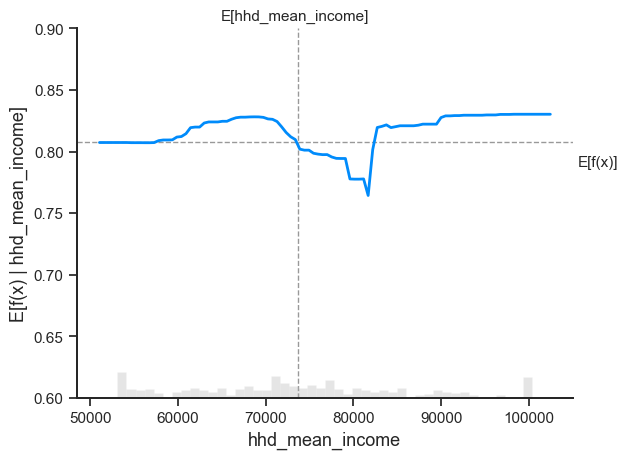

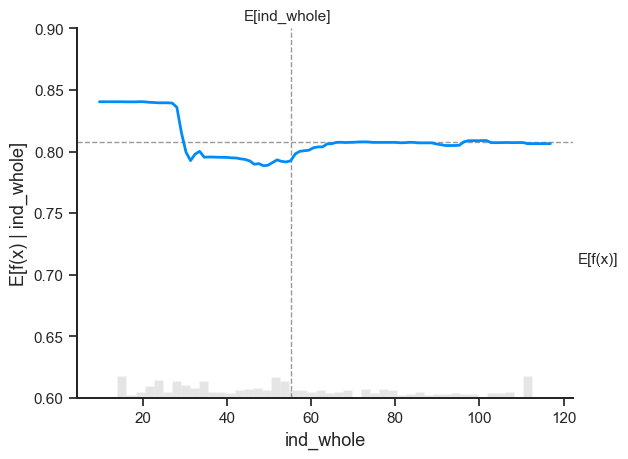

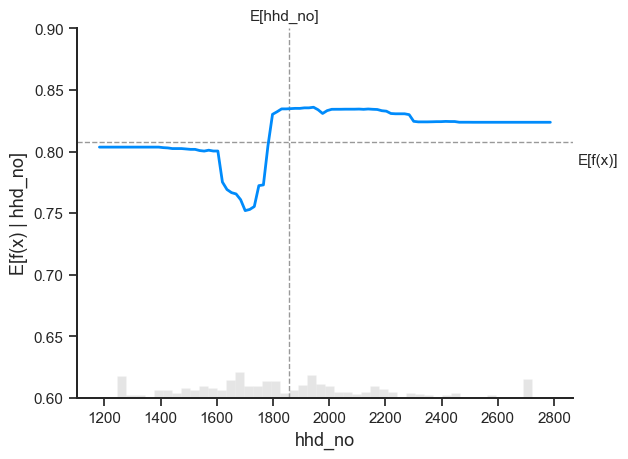

In [15]:
def partial_dependence_plots(features, model_feature_proba, X):
    for feature in features:
        fig, ax = shap.partial_dependence_plot(feature, model_feature_proba, X, model_expected_value=True, feature_expected_value=True, show=False, ice=False)
        ax.set_ylim(0.6, 0.9)
    plt.show()

features_to_plot = ["orig_amounts", "aadt_truck", "hhd_avg_size", "landuse_code", "ROAD_DIREC", "comm_workhome", "comm_workers_per_car", "hhd_mean_income", "ind_whole", "hhd_no"]
partial_dependence_plots(features_to_plot, model_feature_proba, X)